In [1]:
%matplotlib inline

# Kernel Density Estimation

This notebook presents and compares several ways to compute the Kernel Density Estimation (KDE) of the probability density function (PDF) of a random variable. KDE plots are available in usual python data analysis and visualization packages such as [pandas](https://pandas.pydata.org/) or [seaborn](https://seaborn.pydata.org/). These packages relies on statisics pacakges to compute the KDE and this notebook will present you how to compute the KDE either by hand or using [scipy](https://docs.scipy.org).

For a more complete reading about KDE, you should read [this article](https://jakevdp.github.io/PythonDataScienceHandbook/05.13-kernel-density-estimation.html).

In [2]:
import numpy as np
import scipy as sp
from scipy.stats import gaussian_kde
from scipy.stats import norm
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
plt.rcParams["figure.figsize"] = (9, 6)
plt.rcParams["font.size"] = 18

# just for fun
# plt.xkcd(scale=.5, length=50);

The results strongly depend on the version of the used packages. For example, `seaborn` will compute the kde using eihter `scipy` or `statsmodels` and depending on the `scipy` version, the meaning of the kde width is not the same. Hereafter are the package versions used in this notebook.

In [3]:
print(f"Numpy: {np.__version__}")
print(f"Scipy: {sp.__version__}")
print(f"Pandas: {pd.__version__}")
print(f"Seaborn: {sns.__version__}")

Numpy: 1.16.2
Scipy: 1.2.1
Pandas: 0.24.2
Seaborn: 0.9.0


## Sample

This is a data sample that will we used in this notebook.

In [4]:
data = [-20.31275116, -18.3594738, -18.3553103, -14.18406452, -11.67305,
        -11.38179997, -11.3761126, -10.6904519, -10.68305023, -10.34148,
         -8.75222277,  -8.7498553, -6.00130727,   1.45761078,   1.77479,
          1.78314794,   2.6612791]


`seaborn` is a good option to get a quick view of the data. You can plot the data as a *rugplot* and the KDE. In `seaborn` the default kernel is a gaussian kernel.

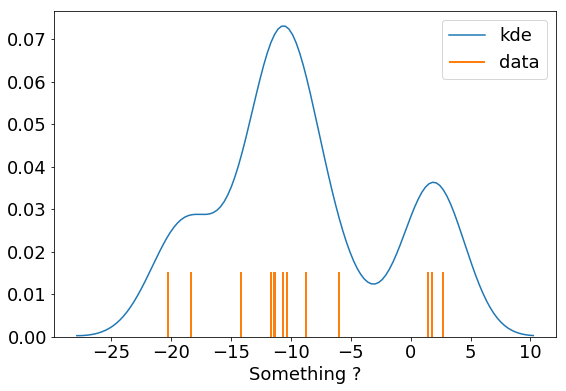

In [5]:
sns.distplot(data, hist=False, rug=True,
             axlabel="Something ?",
             kde_kws=dict(label="kde"),
             rug_kws=dict(height=.2, linewidth=2, color="C1", label="data"))
plt.legend();

## Compute the gaussian KDE by hands

A gaussian KDE is computed from a sum of normal functions of a defined width. It could be computed as follow:

In [6]:
def my_kde(data, width=1, gridsize=100, normalized=True, bounds=None):
    """
    Compute the gaussian KDE from the given sample.
    
    Args:
        data (array or list): sample of values
        width (float): width of the normal functions
        gridsize (int): number of grid points on which the kde is computed
        normalized (bool): if True the KDE is normalized (default)
        bounds (tuple): min and max value of the kde
        
    Returns:
        The grid and the KDE
    """
    # boundaries
    if bounds:        
        xmin, xmax = bounds
    else:
        xmin = min(data) - 3 * width
        xmax = max(data) + 3 * width
        
    # grid points
    x = np.linspace(xmin, xmax, gridsize)
    
    # compute kde
    kde = np.zeros(gridsize)
    for val in data:
        kde += norm.pdf(x, loc=val, scale=width)
        
    # normalized the KDE
    if normalized:
        kde /= sp.integrate.simps(kde, x)
    
    return x, kde

Using our function, the KDE is computed as:

In [7]:
x, kde = my_kde(data, gridsize=200)

Now we can compare with the KDE otained from `seaborn`. The gaussian kernel being the default, we have to give to `seaborn` the same band width, that is `1.` here, using the `bw` keyword.

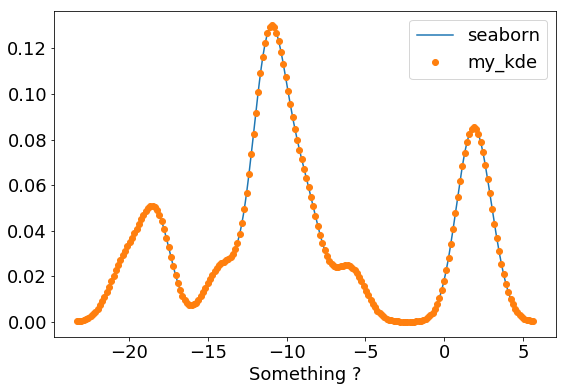

In [8]:
ax = sns.distplot(data, hist=False, axlabel="Something ?",
                  kde_kws=dict(gridsize=200, bw=1, label="seaborn"))
ax.plot(x, kde, "o", label="my_kde")
plt.legend();

## Compute the gaussian KDE with scipy

Using available methods from reliable packages such as `scipy` is always a better option. In addition to save time the functions are generally more efficient and less buggy.

Here we will use the [`gaussian_kde`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.gaussian_kde.html) class from the `scipy.stats` module.

In [9]:
# KDE instance 
bw = 1. / np.std(data)
g_kde = gaussian_kde(dataset=data, bw_method=bw)

# compute KDE
gridsize = 200
g_x = np.linspace(-24, 6, gridsize)
g_kde_values = g_kde(g_x)

Now we can compare with our previous KDE computed by hands. 

**Remark:** In `scipy`, the bandwidth is scaled by the covariance of the input data, that is the standard deviation here. Thus, for comparison, the bandwidth is divided by the standard deviation. 

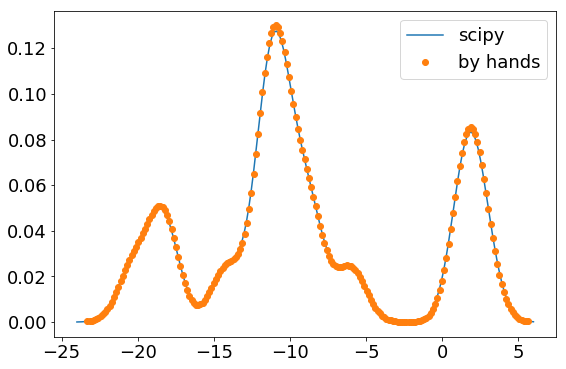

In [10]:
plt.plot(g_x, g_kde_values, label="scipy")
plt.plot(x, kde, "o", label="by hands")
plt.legend();

There are several methods embeded in the `gaussian_kde` class in order to integrate or sample using the new kernel.

Depending on the `bw_method` argument, the class can compute an estimator of the bandwidth which could be obtained from a class attribute.

In [11]:
g_kde = gaussian_kde(dataset=data, bw_method="scott")
print(f"Band width: {g_kde.factor}")
g_kde = gaussian_kde(dataset=data, bw_method="silverman")
print(f"Band width: {g_kde.factor}")

Band width: 0.5674272856715801
Band width: 0.6010325090449528


If you want to use this new value in our `my_kde()` functions, don't forget to scaled the bandwidth by the standard deviation of the input data.

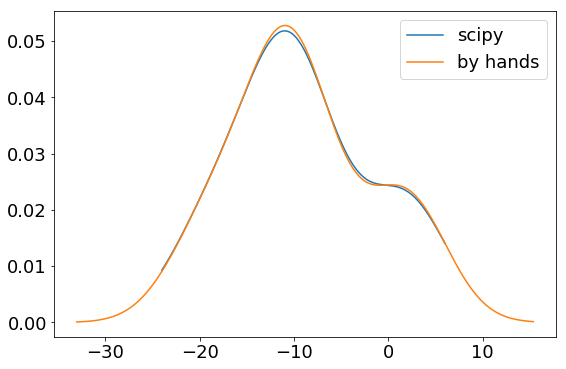

In [12]:
# compute KDE value from gaussian_kde instance
g_kde = gaussian_kde(dataset=data, bw_method="silverman")
g_kde_values = g_kde(g_x)
# our functions with the computed bandwidth
x, kde = my_kde(data, width=g_kde.factor * np.std(data), gridsize=200)
# plot
plt.plot(g_x, g_kde_values, label="scipy")
plt.plot(x, kde, label="by hands")
plt.legend();

### About performances

Hereafter is a comparison of the performances of our functions and scipy `gaussian_kde` class. You can see that scipy is three times faster.

In [13]:
%timeit x, kde = my_kde(data, width=g_kde.factor, gridsize=200)

2.2 ms ± 190 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [14]:
%%timeit 
# KDE instance 
g_kde = gaussian_kde(dataset=data, bw_method=0.14)

# compute KDE
gridsize = 200
g_x = np.linspace(-24, 6, gridsize)
g_kde_values = g_kde(g_x)

755 µs ± 70.6 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


## Comparisons

Now, let us compare the KDE obtained from either our functions, `scipy`, `seaborn` or `pandas`.

In [15]:
df = pd.DataFrame(data, columns=["data"])
df.head()

,data
0,-20.312751
1,-18.359474
2,-18.355310
3,-14.184065
4,-11.673050


Note in the following cell that in `seaborn` (with gaussian kernel) the meaning of the bandwidth is the same as the one in our function (the width of the normal functions summed to obtain the KDE). As `pandas` uses `scipy` the meaning of the band width is different and for comparison, using `scipy` or `pandas`, you have to scale the bandwidth by the standard deviation.

In the plot below, the KDE computed by hands or using `scipy` are shifted vertically for a better comparison.

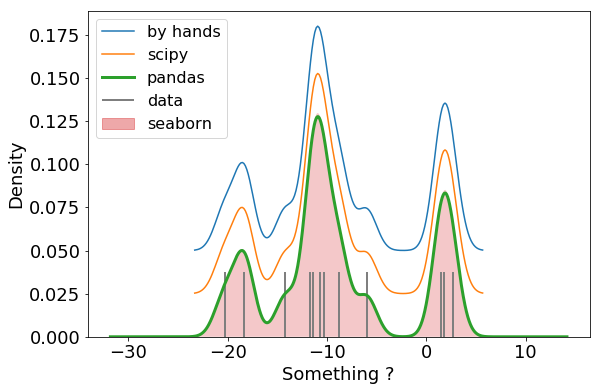

In [16]:
# bandwidth
bw = 1.
bw_sp = bw / np.std(data)

# KDE from our function
ax = plt.subplot()
x, kde = my_kde(data, width=bw, gridsize=200)
ax.plot(x, kde + 0.05, label="by hands")

# scipy
g_kde = gaussian_kde(dataset=data, bw_method=bw_sp)
g_kde_values = g_kde(x)
ax.plot(x, g_kde_values + 0.025, label="scipy")

# pandas
df.data.plot.kde(bw_method=bw_sp, ax=ax, linewidth=3, label="pandas")

# seaborn
sns.distplot(data, hist=False, rug=True, ax=ax,
             axlabel="Something ?",
             kde_kws=dict(gridsize=200, shade=True, bw=bw, linewidth=0),
             rug_kws=dict(height=.2, linewidth=2, color="C7", label="data"))


lgd = plt.legend(fontsize=16);
lines = lgd.get_lines()
lines.append(mpatches.Patch(color="C3", label="seaborn", alpha=.4))
plt.legend(lines, ["by hands", "scipy", "pandas", "data", "seaborn"], fontsize=16);